This is a _working_ notebook. See the `ccdControlIntro` notebook for a more narrative how-to. In this notebook, most cells have acquisition, processing, and plotting.

In [1]:
# All system imports
import logging
import time
import clocks
import fitsio

import numpy as np
import scipy
import scipy.optimize as opt

%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
cam='b9'

import power.PCM as PCM
reload(PCM)

pcm = PCM.PCM(host='pcm-%s' % (cam))
pcm.logger.setLevel(logging.DEBUG)

In [3]:
def gobbleFeeOutput():
    while True:
        ret = fee.readResponse()
        print "got: ", ret
        if ret == '':
            break

def feeUp0():
    print "feeUp0"
    pcm.powerOn('fee')
    time.sleep(4)

def feeUp1():
    global fee
    print "feeUp1"
    logLevel = 20
    fee = feeMod.FeeControl(logLevel=logLevel)
    fee.powerUp(preset='erase')

def feeUp():
    feeUp0()
    feeUp1()
    
def feeBump():
    print "feeBump"

    pcm.powerCmd('fee', False)
    time.sleep(3)
    feeUp0()

def fullBump():
    feeUp1()
    time.sleep(1.5)
    fee.powerDown()
    time.sleep(1)
    pcm.powerOff('fee')
    
def V1():
    for m in ('erase', 'wipe', 'expose', 'read', 'erase'):
        fee.setMode(m)
        time.sleep(1)
        
def V0():
    feeUp0()
    feeUp1()
    fee.setMode('wipe')
    time.sleep(1)
    fee.setMode('expose')
    time.sleep(1)
    fee.setMode('read')
    ccd.readImage(nrows=40, ncols=100, 
                  clockFunc=pfsClocks, doSave=False)
    fee.setMode('erase')
    time.sleep(1)
#    fee.powerDown()
#    time.sleep(1)
    pcm.powerOff('fee')
    time.sleep(1)
    
#feeUp1()
#time.sleep(2)
#feeBump()
#print fee.doGet('voltage','54VP')


In [ ]:
fee.powerDown()
pcm.powerOff('fee')


In [4]:
# FEE connection and initialization.
# Initialize everything to some sane state.
import fee.feeControl as feeMod
reload(feeMod)

pcm.powerOn('fee')
time.sleep(4)
doLoad = False # '/home/pfs/feeMain-2015-09-11_01.hex'
doCalib = False

logLevel = 20
if doLoad:
    fee = feeMod.FeeControl(logLevel=logLevel, noPowerup=True)
    pcm.powerOff('fee')
    time.sleep(0.5)

    pcm.powerOn('fee')
    fee.sendImage(doLoad)

    time.sleep(2)
    pcm.powerCmd('fee', turnOn=False)
    time.sleep(1)
    pcm.powerCmd('fee', turnOn=True)
    time.sleep(4)
    fee = feeMod.FeeControl(logLevel=logLevel, noPowerup=True)
    fee.saveModesOnFee()
    fee.powerUp()
    
fee = feeMod.FeeControl(logLevel=logLevel)
    
if doCalib:
    fee.raw('lp,read')
    fee.raw('cal,CDS')
    fee.raw('cal,bias')
    #for channel in 0,1:
    #    fee.doSet('bias', 'P_off', -1.0, channel=channel) 
    #    fee.doSet('bias', 'S_off', -1.0, channel=channel)
    #    fee.doSet('bias', 'S_on', 3.0, channel=channel)

    time.sleep(1)
    pcm.powerCmd('fee', turnOn=False)
    time.sleep(1)
    pcm.powerCmd('fee', turnOn=True)
    time.sleep(4)
    fee = feeMod.FeeControl(logLevel=logLevel)
    


DEBUG:root:sending '~16\r\n'
DEBUG:root:received 'Success'


Success
SUCCESS
SUCCESS
SUCCESS


In [ ]:
fee.logger.setLevel(20)
#gobbleFeeOutput()
#print fee.device.timeout
for i in range(1):
    ccd1 = fee.sendCommandStr('rt,ccd1')
    ccd0 = fee.sendCommandStr('rt,ccd0')
    print "%s %s" % (ccd0, ccd1)

print fee.sendCommandStr('rt,PA')
print fee.sendCommandStr('rt,FEE')

In [ ]:
refSlope = "p"
masterSlope = "n"

fee.zeroOffsets()
defOffsets = np.array([20]*8)
fee.setOffsets(np.arange(8), defOffsets, leg=masterSlope)
# fee.setOffsets(np.arange(8), defOffsets, leg='n')

In [ ]:
%pdb off
fee.logger.setLevel(20)
fee.setMode('read')
t0 = time.time()
feeCards = fee.statusAsCards()
t1 = time.time()
fee.setMode('erase')

print "that took %0.3f s" % (t1-t0)
fee.printStatus()



In [ ]:
cmds = 'gb', 'rb'
chans = 'ch0', 'ch1'

fee.logger.setLevel(20)
for mode in 'BT1', 'expose', 'read', 'wipe', 'erase':
    fee.setMode(mode)
    time.sleep(0.25)
    
    print "======== %s" % mode
    
    for k in fee.allKeys('bias'):
        print "%-8s " % k,
        for chan in chans:
            for cmd in cmds:
                v = fee.sendCommandStr('%s,%s,%s' % (cmd, k, chan))
                print "%6s " % (v),
            print "    ",
        print

In [ ]:
if True:
    fee.logger.setLevel(5)
    fee.device.setTimeout(2.0)
    print fee.saveModesOnFee('BT1')
    fee.device.setTimeout(0.5)
    fee.logger.setLevel(20)


In [ ]:
if False:
    print fee.doGet('serial', 'FEE')
    fee.unlockConfig()
    fee.setSerial('ADC', 3063060)
    fee.setSerial('PA0', 186)
    fee.lockConfig()
print fee.doGet('serial', 'FEE')
print fee.doGet('serial', 'ADC')
print fee.doGet('serial', 'PA0')


In [5]:
# FPGA connection and initialization.
# All the reloads are to make sure that new code gets picked up
import fpga as fpgaMod
import fpga.ccdFuncs as ccdFuncs
import fpga.nbFuncs as nbFuncs

reload(fpgaMod)
reload(fpgaMod.ccd)
reload(fpgaMod)

ccd = fpgaMod.CCD(9, 'red', adc18bit=1)  # adc18bit=2 reads the low bits.
ccd.pciReset()
print "FPGA version: 0x%08x" % (ccd.peekWord(0))

FPGA version: 0xbeefa070


In [6]:
# Load the clock tables. pfsClocks is used for each readout.
import clocks
import clocks.read
reload(clocks.read)
reload(clocks)

pfsClocks = clocks.read.readClocks
pre, pix, post = pfsClocks()


In [ ]:
def setGains(_lev):
    refSlope = "p"
    masterSlope = "n"

    _ref = _lev
    _master = _
    defOffsets = np.array([_lev]*8)
    fee.setOffsets(np.arange(8), defOffsets, leg=masterSlope)

    defOffsets = np.array([_lev*(-55.0/-66)]*8)
    fee.setOffsets(np.arange(8), defOffsets, leg=refSlope)


def gainTest1(offset, nrows=200, clockFunc=pfsClocks, doUnwrap=65000, statCols=slice(30,-30)):
        setGains(offset)
        
        argDict = dict(everyNRows=100, ampList=amps, ccd=ccd)                                                                                           

        
        im, files = ccd.readImage(nrows=nrows, rowFunc=ccdFuncs.rowStats, rowFuncArgs=argDict, doSave=False,                                        
                                  clockFunc=clockFunc)                                                                                              
        if doUnwrap is not False:                                                                                                                   
            im = im.astype('i4')                                                                                                                    
            hi_w = im > doUnwrap                                                                                                                    
            if hi_w.sum() > 0:                                                                                                                      
                print "!!!! unwraping %d pixels !!!!" % (hi_w.sum())                                                                                
                im[hi_w] -= 65535                                                                                                                   
                                                                                                                                                    
        newLevels, devs = nbFuncs.ampStats(im, statCols, ccd=ccd)                                                                                           
        print "means(%0.3f): %s" % (offset, nbFuncs.fmtArr(newLevels))                                                                                      
        print "devs (%0.3f): %s" % (offset, nbFuncs.fmtArr(devs))      
        
        return newLevels, devs


In [ ]:
ret = gainTest1(100)


0000 162.5 576.2 380.2 64972.2 111.9 508.6 178.9 297.6 2523.28 5794.10 4612.62 5628.51 1670.00 5427.17 2784.28 3931.65 OK
0100 61.6 37.7 45.6 23.5 47.1 48.5 65.4 64.9 0.77 0.74 0.72 0.89 0.73 0.76 0.75 0.75 OK
0199 61.9 38.6 46.0 23.6 47.5 49.1 65.7 64.8 0.81 0.75 0.69 0.88 0.74 0.78 0.78 0.74 OK
readTime = 1.71662; expected 1.58614
0000 62.2 40.0 64967.3 22.4 47.6 49.6 65.8 64.7 0.79 0.75 2766.71 0.98 0.79 0.79 0.83 0.77 OK
0100 62.3 40.3 65319.5 22.1 47.8 49.7 65.8 64.6 0.79 0.78 8.70 0.88 0.73 0.72 0.75 0.78 OK
0199 62.3 40.6 65323.7 22.1 47.8 49.8 65.8 64.5 0.82 0.74 9.52 0.85 0.74 0.76 0.81 0.76 OK
readTime = 1.72001; expected 1.58614
!!!! unwraping 110308 pixels !!!!
means(0.000): [62.2560 40.2956 -193.6272 22.2791 47.7457 49.6831 65.7501 64.5967]
devs (0.000): [0.7624 0.7623 1438.2835 0.8604 0.7218 0.7459 0.7642 0.7526]

0000 2207.3 2183.5 2045.8 2166.9 2193.6 2196.5 2210.9 2207.3 91.31 91.28 2695.93 91.38 91.45 91.45 91.34 91.27 OK
0100 2211.4 2187.8 1930.9 2171.4 2197.7 2200.8

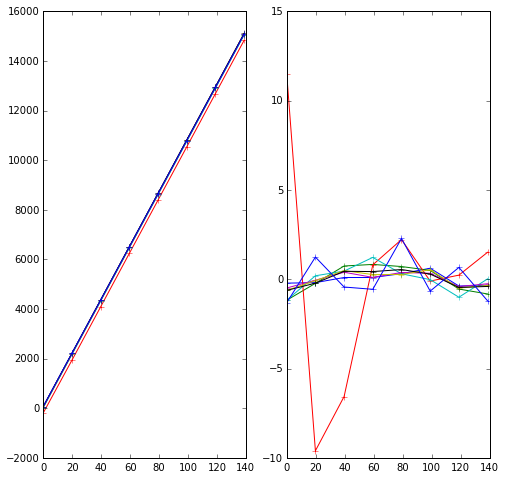

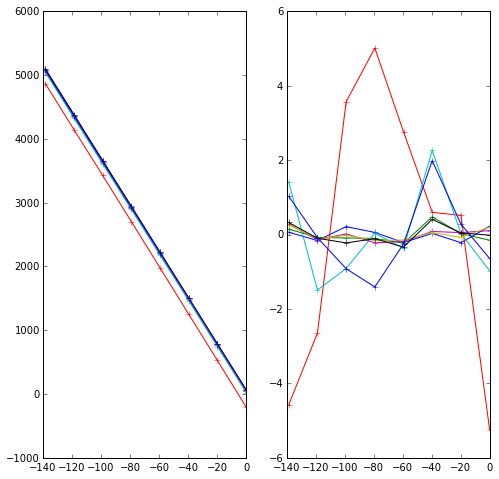

In [7]:
reload(nbFuncs)

# fee.setMode('read')
doGainCurve = True
if doGainCurve:
    fee.zeroOffsets()
    stepSize = 19.8
    statCols = slice(50,-50)
    amps = np.arange(8)
    noffsets, nlevels = nbFuncs.gainCurve(ccd, fee, amps=amps, stepSize=stepSize, leg='n', offLimit=150,
                                          statCols=statCols, doUnwrap=65000, clockFunc=pfsClocks, nrows=200)
    poffsets, plevels = nbFuncs.gainCurve(ccd, fee, amps=amps, stepSize=-stepSize, leg='p', offLimit=150,
                                          statCols=statCols, doUnwrap=65000, clockFunc=pfsClocks, nrows=200)
    
    print
    nfits = nbFuncs.plotGains(noffsets, nlevels, amps=amps)
    print
    pfits = nbFuncs.plotGains(poffsets, plevels, amps=amps)

In [ ]:
%pdb off
reload(ccdFuncs)
reload(nbFuncs)

allAmps = np.arange(8)
badAmps = []

dummyCcd = False
if not dummyCcd:
    goodAmps = np.arange(8)

    startStep = 5
    levels = 1000
else:
    goodAmps = np.arange(4) + 4
    
    startStep = 10
    levels = np.zeros(8)
    levels[4:] = [10000,25000,20000,15000]

ncols=300

doTune = False
if doTune:
    offs, devs, gains = nbFuncs.tuneLevels(ccd, fee, levels=levels, adjOffset=5, 
                                           amps=goodAmps,
                                           statCols=slice(2,None), 
                                           maxLoops=10, nrows=200, 
                                           startStep=startStep, 
                                           startOffset=startStep,
                                           sigTol=4, 
                                           clockFunc=pfsClocks, 
                                           legs='np', # useGains=nfits[:,0], 
                                           doZero=True, doUnwrap=65000)

    defOffsets = offs


In [ ]:
reload(ccdFuncs)
reload(nbFuncs)

fee.setMode('erase')

# fee.sendCommandStr('sf,slow')

goodAmps = np.arange(8) #[3,4,5,6, 7] # np.arange(8)
badAmps = []

nrows = 4340          # How many rows to read out.
ncols = 600
selectRows = slice(100,nrows-200)
selectCols = None # slice(5,5)
pcols = np.arange(32,ncols-64)    # Which cols to plot
statCols = np.arange(40,ncols-64) # Which cols to use for stats
prow = (selectRows.stop+1)/2
prows = [prow-100,prow,prow+500]       # which rows to plot
fftAmps = []

figWidth = 12

argDict = dict(everyNRows=300, ampList=goodAmps, cols=statCols, ccd=ccd)

siggenAmp = None
if siggenAmp is None:
    try:
        switch.setCoils(off=range(16))
    except:
        pass
else:
    switch.chooseCoil(siggenAmp)

comment = 'pure test'
flushRead = False
doFile = None # '/data/pfs/2015-06-02/PFSA-00000954.fits'
doSave = True
if doFile:
    im = fitsio.read(doFile)
else:
    fee.setMode('read')
    time.sleep(1)
    if flushRead:
        im, files = ccd.readImage(nrows=100, ncols=ncols, 
                                  rowFunc=ccdFuncs.rowStats, rowFuncArgs=argDict, 
                                  clockFunc=pfsClocks, doSave=False)
    im, files = ccd.readImage(nrows=nrows, ncols=ncols, 
                              rowFunc=ccdFuncs.rowStats, rowFuncArgs=argDict, 
                              clockFunc=pfsClocks, doSave=doSave,
                              comment=comment, addCards=feeCards)
    fee.setMode('erase')

if selectRows is not None:
    im = im[selectRows]
if selectCols is not None:
    im = im[:,selectCols]
    
im = im.astype('i4')
if False:
    hi_w = np.where(im > 63000)
    im[hi_w] -= 65535

if siggenAmp is None:
    amp4Mask = ccd.ampidx(4, im)
else:
    amp4Mask = ccd.ampidx(siggenAmp, im)

#amp6Mask = ccd.ampidx(6, im)
#im[:, amp6Mask] -= im[:, amp6Mask].mean()
#im[:, amp6Mask] += im[:, ccd.ampidx(4, im)].mean()

means,devs = nbFuncs.ampStats(im, ccd=ccd, cols=statCols)
print "means:", nbFuncs.fmtArr(means, format="%0.3f")
print "devs: ", nbFuncs.fmtArr(devs, format="%0.3f")
med4 = np.median(im[prow, amp4Mask])
max4 = np.max(im[prow, amp4Mask])
min4 = np.min(im[prow, amp4Mask])

inject = 0.3
print "peak: ", med4, min4, max4, max4-med4, (max4-med4)/inject, inject/(max4-med4)

# print "shape: %s dtype: %s" % (str(im.shape), im.dtype)
    
if len(files) > 0:
    path = files[0]
    imName = '/'.join(path.split('/')[-2:])
    print "file: %s" % (path)

#focusAmp = 0             # Which amp to focus on
#focusMask = ccd.ampidx(focusAmp, im)[pcols]

# plot one or more rows across the entire image
nbFuncs.plotRows(im, prows, imName=imName, figWidth=figWidth, pixRange=200 if siggenAmp is not None else None)

# plot one row for each the "good" amps
peaks = None # np.arange(1, ncols, 50)
if siggenAmp is not None:
    channel = siggenAmp/4
    amps0 = [siggenAmp]
    amps1 = goodAmps[np.where((goodAmps/4 == channel) & (goodAmps != siggenAmp))]
    amps2 = goodAmps[np.where(goodAmps/4 != channel)]

    nbFuncs.plotAmps(im, amps=amps0, row=prow, cols=pcols, 
                 plotOffset=10, fig=None, figWidth=figWidth, 
                 peaks=peaks, clipPeaks=True)

    nbFuncs.plotAmps(im, amps=amps1, row=prow, cols=pcols, 
                 plotOffset=100, fig=None, figWidth=figWidth, 
                 peaks=peaks, clipPeaks=True)

    nbFuncs.plotAmps(im, amps=amps2, row=prow, cols=pcols, 
                 plotOffset=10, fig=None, figWidth=figWidth)
else:
    nbFuncs.plotAmps(im, amps=goodAmps, row=prow, cols=pcols, 
                     plotOffset=10, fig=None, figWidth=figWidth, 
                     peaks=peaks, clipPeaks=True)

# f.axes[0].set_ylim(-50, 150)

# plot any bad amps individually
for a in badAmps:
    nbFuncs.plotAmps(im, amps=[a], row=prow, cols=pcols, figWidth=figWidth)

# show a grid of histograms.
hists = nbFuncs.ampHistGrid(im, ccd, cols=pcols, histRange=20, figWidth=figWidth)

# show a grid of raw amp images.
nbFuncs.rawAmpGrid(im, ccd, cols=pcols, figWidth=figWidth, showFfts=True)

fftAmps = [] # np.arange(8) # [1,2,5] # [5,6]
if len(fftAmps) > 0:    
    
    fftFig = plt.figure(figsize=(figWidth, figWidth/4))
    for a in fftAmps:
        fftFig = plt.figure(figsize=(figWidth, figWidth/4))
        fftMask = ccd.ampidx(a, im)[pcols]
        ampSeg = im[prow,fftMask]
        freqs, fft, peak_ii = ccdFuncs.plotTopPeriods(ampSeg, topN=3)


#fig.colorbar(pp)
#plt.tight_layout()